<a href="https://colab.research.google.com/github/malacosteus/MIPT/blob/main/ML/Lab2_DL_part3_poetry_finv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch
import torch.nn as nn

from collections import Counter

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/

---

ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:

if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt##

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2022-06-30 02:39:03--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.007s  

2022-06-30 02:39:03 (17.1 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

#text = "".join(text).lower()

#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
#assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
#print('OK!')

### Data loading: "Евгений Онегин"


In [ ]:
#!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
#with open('onegin.txt', 'r') as iofile:
#    text = iofile.readlines()
    
#text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# get list of words from document
def text2words(text):
    lines = text.split('\n')
    lines = [line.strip(r'\"') for line in lines]
    words = ' '.join(lines).split()

    punct = set(string.punctuation)
    words = [''.join([char for char in list(word) if char not in punct]) for word in words]

    return words

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(text).lower()
words = text2words(text)

In [ ]:
text

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as the riper should by time decease,\n  his tender heir might bear his memory:\n  but thou, contracted to thine own bright eyes,\n  feed'st thy light's flame with self-substantial fuel,\n  making a famine where abundance lies,\n  thy self thy foe, to thy sweet self too cruel:\n  thou that art now the world's fresh ornament,\n  and only herald to the gaudy spring,\n  within thine own bud buriest thy content,\n  and tender churl mak'st waste in niggarding:\n    pity the world, or else this glutton be,\n    to eat the world's due, by the grave and thee.\n\n  ii\n\n  when forty winters shall besiege thy brow,\n  and dig deep trenches in thy beauty's field,\n  thy youth's proud livery so gazed on now,\n  will be a tatter'd weed of small worth held:\n  then being asked, where all thy beauty lies,\n  where all the treasure of thy lusty days;\n  to say, within thine own deep sunken eyes,\n  were

Put all the characters, that you've seen in the text, into variable `tokens`.

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
wordfreq = Counter(words)
tokens = sorted(wordfreq, key=wordfreq.get)
num_tokens = len(tokens)

In [ ]:
# we prefer "2" to "_to_"

# Your great code here
# dict <index>:<char>
idx2token = {k:w for k,w in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token2idx = {w:k for k,w in idx2token.items()}

In [ ]:
# various parameters for nets
batch_size = 16
seq_size = 32
gradients_norm = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
class rnn_net(nn.Module):
    def __init__(self, n_vocab, embedding_size=64, rnn_size=64):
        super(rnn_net, self).__init__()
        self.rnn_size = rnn_size

        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.RNN(embedding_size, rnn_size, batch_first=True)
        self.dense = nn.Linear(rnn_size, n_vocab)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state
    
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.rnn_size))


class lstm_net(nn.Module):
    def __init__(self, n_vocab, embedding_size=64, lstm_size=64):
        super(lstm_net, self).__init__()
        self.lstm_size = lstm_size

        self.embedding = nn.Embedding(n_vocab, embedding_size)
        self.lstm = nn.LSTM(embedding_size, lstm_size, batch_first=True)
        self.dense = nn.Linear(lstm_size, n_vocab)
        
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.dense(output)

        return logits, state
    
    def zero_state(self, batch_size):
        return (torch.zeros(1, batch_size, self.lstm_size),torch.zeros(1, batch_size, self.lstm_size))

In [ ]:
def get_batches(words, token2idx, batch_size, seq_size):
    word_ints = [token2idx[word] for word in words]
    num_batches = int(len(word_ints) / (batch_size * seq_size))
    Xs = word_ints[:num_batches*batch_size*seq_size]
    Ys = np.zeros_like(Xs)
    Ys[:-1] = Xs[1:]
    Ys[-1] = Xs[0]
    Xs = np.reshape(Xs, (num_batches*batch_size, seq_size))
    Ys= np.reshape(Ys, (num_batches*batch_size, seq_size))
    
    for i in range(0, num_batches*batch_size, batch_size):
        yield Xs[i:i+batch_size, :], Ys[i:i+batch_size, :]

def plt1(loss):
    plt.figure(figsize = (10 , 10))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.plot(np.arange(len(loss)) + 1, loss, label="Training loss")

    plt.legend()
    plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
def train_rnn(net, words, vocab_to_int, int_to_vocab, n_vocab, n_epoch):
    net = net.to(device)
    net.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    loss_train = []
    
    for epoch in tqdm(range(n_epoch)):
        batches = get_batches(words, vocab_to_int, batch_size, seq_size)
        state_h = net.zero_state(batch_size)

        state_h = state_h.to(device)
        for x, y in batches:
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            optimizer.zero_grad()

            logits, state_h = net(x, state_h)
            loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()

            loss_value = loss.item()
            loss_train.append(loss_value)

            loss.backward()            
            optimizer.step()

        print(f"Epoch: {epoch}; Loss: {loss_value}")

    return loss_train


def train_lstm(net, words, vocab_to_int, int_to_vocab, n_vocab, n_epoch):
    net = net.to(device)
    net.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    loss_train = []
    
    for epoch in tqdm(range(n_epoch)):
        batches = get_batches(words, vocab_to_int, batch_size, seq_size)
        state_h, state_c = net.zero_state(batch_size)

        state_h = state_h.to(device)
        state_c = state_h.to(device)
        for x, y in batches:
            x = torch.tensor(x).to(device)
            y = torch.tensor(y).to(device)

            optimizer.zero_grad()

            logits, (state_h, state_c) = net(x, (state_h, state_c))
            loss = criterion(logits.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_h.detach()

            loss_value = loss.item()
            loss_train.append(loss_value)

            loss.backward()
            optimizer.step()

        print(f"Epoch: {epoch}; Loss: {loss_value}")

    return loss_train

In [ ]:
rnn_model = rnn_net(num_tokens)
loss = train_rnn(rnn_model, words, token2idx, idx2token, num_tokens, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0; Loss: 6.4438090324401855
Epoch: 1; Loss: 5.982717514038086
Epoch: 2; Loss: 5.63507080078125
Epoch: 3; Loss: 5.12992525100708
Epoch: 4; Loss: 4.770852088928223
Epoch: 5; Loss: 4.451077938079834
Epoch: 6; Loss: 4.119347095489502
Epoch: 7; Loss: 3.925241470336914
Epoch: 8; Loss: 3.7061007022857666
Epoch: 9; Loss: 3.475881814956665
Epoch: 10; Loss: 3.2830538749694824
Epoch: 11; Loss: 3.1014461517333984
Epoch: 12; Loss: 2.9516029357910156
Epoch: 13; Loss: 2.8256754875183105
Epoch: 14; Loss: 2.7410900592803955
Epoch: 15; Loss: 2.630300283432007
Epoch: 16; Loss: 2.5135340690612793
Epoch: 17; Loss: 2.4103000164031982
Epoch: 18; Loss: 2.3832223415374756
Epoch: 19; Loss: 2.3314602375030518
Epoch: 20; Loss: 2.2103559970855713
Epoch: 21; Loss: 2.1562671661376953
Epoch: 22; Loss: 2.0868701934814453
Epoch: 23; Loss: 2.053717851638794
Epoch: 24; Loss: 1.9522805213928223
Epoch: 25; Loss: 1.9586474895477295
Epoch: 26; Loss: 1.8578392267227173
Epoch: 27; Loss: 1.8199167251586914
Epoch: 28; Los

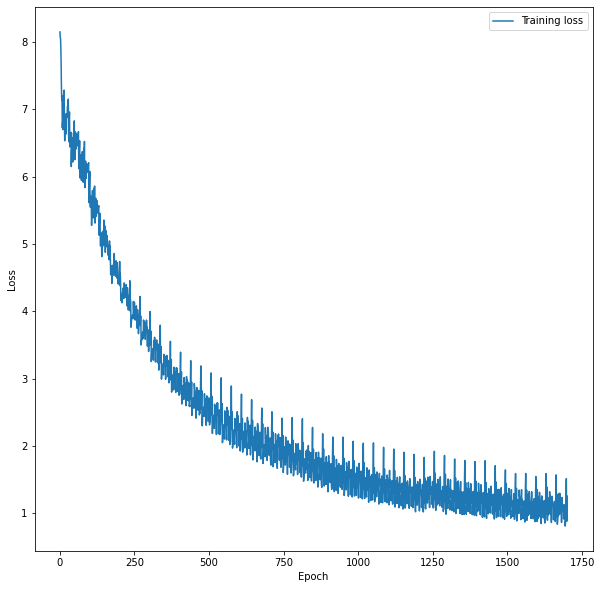

In [ ]:
plt1(loss)

In [ ]:
import torch.nn.functional as F

MAX_LENGTH  = 128
def generate_sample_rnn(char_rnn, seed_phrase=['hello'], max_length=MAX_LENGTH, temperature=1.0, token2idx=token2idx, idx2token=idx2token):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    char_rnn.eval()
    x_sequence = [token2idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.zero_state(1)
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence, hid_state)
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence, hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][-1]

        next_ix = np.random.choice(len(idx2token), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ' '.join([idx2token[ix] for ix in x_sequence.data.numpy()[0]])


def generate_sample_lstm(char_rnn, seed_phrase=['hello'], max_length=MAX_LENGTH, temperature=1.0, token2idx=token2idx, idx2token=idx2token):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    char_rnn.eval()
    x_sequence = [token2idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    (hid_state_h, hid_state_c) = char_rnn.zero_state(1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, (hid_state_h, hid_state_c)  = char_rnn(x_sequence, (hid_state_h, hid_state_c))
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, (hid_state_h, hid_state_c) = char_rnn(x_sequence, (hid_state_h, hid_state_c))
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0][-1]

        next_ix = np.random.choice(len(idx2token), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ' '.join([idx2token[ix] for ix in x_sequence.data.numpy()[0]])

In [ ]:
# An example of generated text.
generated_text = generate_sample_rnn(rnn_model, seed_phrase=['that', 'thereby'], max_length=12, temperature=0.2)
print(generated_text)

that thereby abundance public means green no more than in eternal lines


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
lstm_model = lstm_net(num_tokens)
loss = train_lstm(lstm_model, words, token2idx, idx2token, num_tokens, 50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0; Loss: 6.459197044372559
Epoch: 1; Loss: 5.996891498565674
Epoch: 2; Loss: 5.700797080993652
Epoch: 3; Loss: 5.318845748901367
Epoch: 4; Loss: 4.973910331726074
Epoch: 5; Loss: 4.648543357849121
Epoch: 6; Loss: 4.351592540740967
Epoch: 7; Loss: 4.0965471267700195
Epoch: 8; Loss: 3.8836889266967773
Epoch: 9; Loss: 3.673949956893921
Epoch: 10; Loss: 3.497861385345459
Epoch: 11; Loss: 3.341287612915039
Epoch: 12; Loss: 3.2641689777374268
Epoch: 13; Loss: 3.104680061340332
Epoch: 14; Loss: 2.963369846343994
Epoch: 15; Loss: 2.823122262954712
Epoch: 16; Loss: 2.698139190673828
Epoch: 17; Loss: 2.598137855529785
Epoch: 18; Loss: 2.474733591079712
Epoch: 19; Loss: 2.3626949787139893
Epoch: 20; Loss: 2.290126085281372
Epoch: 21; Loss: 2.189635753631592
Epoch: 22; Loss: 2.098062753677368
Epoch: 23; Loss: 2.0214524269104004
Epoch: 24; Loss: 1.9311779737472534
Epoch: 25; Loss: 1.8433917760849
Epoch: 26; Loss: 1.7784785032272339
Epoch: 27; Loss: 1.7053134441375732
Epoch: 28; Loss: 1.65829

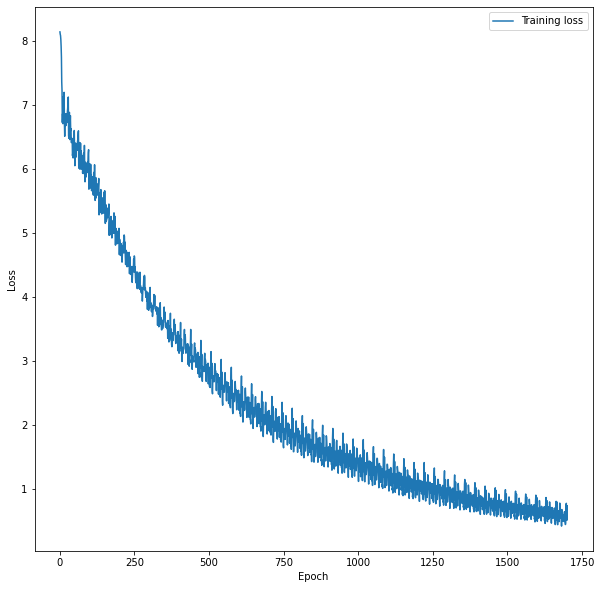

In [ ]:
plt1(loss)

In [ ]:
generate_sample_lstm(lstm_model, seed_phrase=['that', 'thereby'], max_length=12, temperature=0.2)

'that thereby thou wilt not be so bold although i do doing'

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
seeds = [['that', 'thereby'], ['that', 'thereby'], ['that', 'thereby'], ['that', 'thereby'], ['that', 'thereby']]
def make_temperature_test(model, temperatures, seeds, lngth=50):
    for temp, seed in zip(temperatures, seeds):
         print(f"temperature = {temp}")
         print(generate_sample_lstm(model, seed_phrase=seed, max_length=lngth, temperature=temp))
         print("\n")

In [ ]:
make_temperature_test(lstm_model, temperatures, seeds)

temperature = 0.1
that thereby thou wilt not from me as with thy sweet love rememberd such wealth brings and in their badness reign cxxii thy gift thy will i will acquaintance strangle and look strange they than no more to hear why hearst thou art so possessd with murderous hate that gainst


temperature = 0.2
that thereby thou wilt thou then take the world should task you to recite what merit lived in me that i that beauty still three winters cold have drawn is not enough that they behold when i sleep in dreams they look on thee and darkly bright are bright in


temperature = 0.5
that thereby thou art so possessd with murderous hate that gainst thy memory blame savage extreme rude cruel not to trust enjoyd no sooner but despised straight past reason hunted and no sooner but despised straight past reason hunted and no sooner but despised every thing argument that to the


temperature = 1.0
that thereby thou then not to thyself so will some in their hawks and hounds some in their horse 

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
torch.save(lstm_model, "./lstm_model")
model_load = torch.load("./lstm_model")
make_temperature_test(model_load, temperatures, seeds)

temperature = 0.1
that thereby thou wilt no praise to thee and i have seen by times fell hand defacd the richproud cost of these all or all my heart to me richer than wealth prouder than garments costs of me so as testy sick men when your to be your being shall


temperature = 0.2
that thereby thou wilt no praise to thee the scope and tenure of love and in my jail and yet thou wilt for i have seen by times fell hand defacd the richproud cost of his beauty new from his edge xcvi some part so either never shaken it is


temperature = 0.5
that thereby thou contracted to be my comfort still but thou wilt no it is my love and all the world unbless some in their bodys force some suspect to make the world may show who his spoil of small glory live for fear of me so as testy sick


temperature = 1.0
that thereby thou contracted to come if it be then delight they in thee of heart xlvii betwixt mine eye well in your sweet self resemble creating every bad a perfect ceremony rhyme but this world o

**Analysis of results**

We can see that LSTM was managed to achieve better loss compared to RNN. If we check generated sequences by ourself the difference in poeticl vales of RNN and LSTM output is not obvious.

We can observe that with increase in temperature generated text reads less like poetry. It is expected because temperature parameters control randomness of our generated text.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)